# SIR models with CovsirPhy

In [3]:
# imports 
import pandas as pd
import covsirphy as cs
import matplotlib.pyplot as plt
from pprint import pprint

### Load the data

In [2]:
# loading the data -> stored in kaggle/input
# data will be downloaded if existing files are older than 24h
kaggle_path = sys.path[0] + '/../kaggle/input'
data_loader = cs.DataLoader(kaggle_path)

# The number of cases and population values in jhu format
jhu_data = data_loader.jhu()

#cases and deaths whole dataset
total_df = jhu_data.total()

Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan
Retrieving datasets from COVID-19 Data Hub https://covid19datahub.io/
	Please set verbose=2 to see the detailed citation list.
Retrieving datasets from Our World In Data https://github.com/owid/covid-19-data/
Retrieving datasets from COVID-19 Open Data by Google Cloud Platform https://github.com/GoogleCloudPlatform/covid-19-open-data


### Prepare the data

The first case in Switzerland was confirmed on 2020-02-24.

In [4]:
# get the population size at the starting point
whole_df = jhu_data.cleaned()
whole_df = whole_df.loc[(whole_df["Country"] == "Switzerland")].copy()
whole_df['Date'] = pd.to_datetime(whole_df['Date'])

# define a time range
start_date = pd.to_datetime('2020-09-01')
end_date = pd.to_datetime('2020-12-01')
mask = (whole_df['Date'] >= start_date) & (whole_df['Date'] <= end_date)
df_timerange = whole_df.loc[mask]

# drop provinces
province_mask = df_timerange["Province"] == "-"
df_timerange = df_timerange.loc[province_mask]
df_timerange.index = pd.RangeIndex(len(df_timerange))

In [5]:
df_timerange

,Date,ISO3,Country,Province,Confirmed,Infected,Fatal,Recovered,Population
0,2020-09-01,CHE,Switzerland,-,42959,4887,1772,36300,8513227
1,2020-09-02,CHE,Switzerland,-,43376,5101,1775,36500,8513227
2,2020-09-03,CHE,Switzerland,-,43814,5538,1776,36500,8513227
3,2020-09-04,CHE,Switzerland,-,44241,5963,1778,36500,8513227
4,2020-09-05,CHE,Switzerland,-,44536,5656,1780,37100,8513227
...,...,...,...,...,...,...,...,...,...
87,2020-11-27,CHE,Switzerland,-,322966,96221,4645,222100,8513227
88,2020-11-28,CHE,Switzerland,-,325277,98443,4734,222100,8513227
89,2020-11-29,CHE,Switzerland,-,326968,100050,4818,222100,8513227
90,2020-11-30,CHE,Switzerland,-,332236,77123,4913,250200,8513227


### setting up a simple SIR model

In [6]:
# setting parameter for the model
params = {'theta': 0.005, 'kappa': 0.005, 'rho': 0.1, 'sigma': 0.05}
start_dict = {'Fatal or Recovered': 1772 + 36300, 'Infected': 4887, 'Susceptible': 8513227 - 4887 - 36300}
population = 8513227
days = (end_date - start_date).days
print(days)

91


In [7]:
model = cs.SIR
model.EXAMPLE["param_dict"] = params
model.EXAMPLE['y0_dict'] = start_dict
model.EXAMPLE['population'] = population
model.EXAMPLE['step_n'] = days

# Set tau value and start date of records
example_data = cs.ExampleData(tau=1440, start_date="01Sep2020")
# Model name
print(cs.SIR.NAME)
# Example parameter values
pprint(cs.SIR.EXAMPLE, compact=True)

SIR
{'param_dict': {'kappa': 0.005, 'rho': 0.1, 'sigma': 0.05, 'theta': 0.005},
 'population': 8513227,
 'step_n': 91,
 'y0_dict': {'Fatal or Recovered': 38072,
             'Infected': 4887,
             'Susceptible': 8472040}}


In [8]:
model = cs.SIR
area = {"country": "Switzerland"}
# Add records with SIR model
example_data.add(model, **area)


# Records with model variables
df = example_data.cleaned()
df

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered,ISO3,Population
0,2020-09-01,Switzerland,-,42959,4887,0,38072,-,8513227.0
1,2020-09-02,Switzerland,-,43457,5135,0,38322,-,8513227.0
2,2020-09-03,Switzerland,-,43981,5395,0,38586,-,8513227.0
3,2020-09-04,Switzerland,-,44531,5669,0,38862,-,8513227.0
4,2020-09-05,Switzerland,-,45110,5957,0,39153,-,8513227.0
...,...,...,...,...,...,...,...,...,...
87,2020-11-27,Switzerland,-,685038,311461,0,373577,-,8513227.0
88,2020-11-28,Switzerland,-,714231,324751,0,389480,-,8513227.0
89,2020-11-29,Switzerland,-,744549,338490,0,406059,-,8513227.0
90,2020-11-30,Switzerland,-,776018,352682,0,423336,-,8513227.0


In [9]:
# prepare the result dataframe
res_df = df.drop(["Country", "Province", "Confirmed", "ISO3", "Population"], axis = 1)

# add results from the model
res_df["actual Infected"] = df_timerange["Infected"]

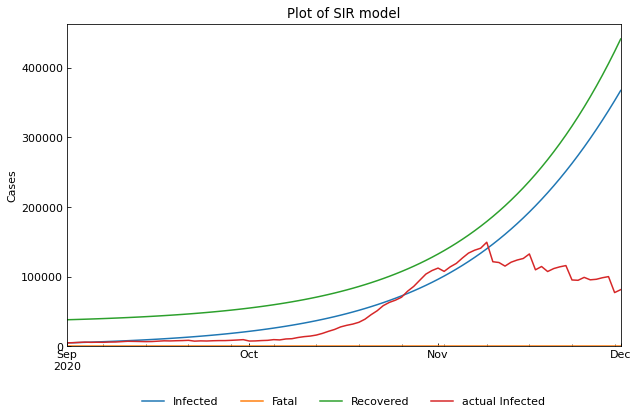

,Date,Infected,Fatal,Recovered,actual Infected
0,2020-09-01,4887,0,38072,4887
1,2020-09-02,5135,0,38322,5101
2,2020-09-03,5395,0,38586,5538
3,2020-09-04,5669,0,38862,5963
4,2020-09-05,5957,0,39153,5656
...,...,...,...,...,...
87,2020-11-27,311461,0,373577,96221
88,2020-11-28,324751,0,389480,98443
89,2020-11-29,338490,0,406059,100050
90,2020-11-30,352682,0,423336,77123


In [10]:
#cs.line_plot(df.set_index("Date"), title=f"Example data of {model.NAME} model", y_integer=True)
cs.line_plot(res_df.set_index("Date"), title=f"Plot of {model.NAME} model", y_integer=True)
res_df

### Creating scenarios of SIR model


In [94]:
# baseline of scenario

preset_dict = cs.SIR.EXAMPLE['param_dict']

In [95]:

# create a scenario

snl = cs.Scenario(tau = 1440, **area)
snl.register(example_data)

# get the records of the scenario instance

record_df = snl.records(show_figure = False)

In [96]:
# Set 0th phase fro eg from 01Sep2020 to 01Dec2020 with preset parameter values

snl.clear(include_past=True)
snl.add(end_date="01Dec2020", model=model, **preset_dict)
# Show summary
snl.summary()

,Type,Start,End,Population,ODE,Rt,rho,sigma,tau,1/beta [day],1/gamma [day]
0th,Past,01Sep2020,01Dec2020,8513227,SIR,2.0,0.1,0.05,1440,10.0,20.0


In [97]:
# Add main scenario
snl.add(end_date="31Mar2021", name="Main")
snl.add(end_date="01Jul2022", name='Main')
snl.summary()

,Type,Start,End,Population,ODE,Rt,rho,sigma,tau,1/beta [day],1/gamma [day]
0th,Past,01Sep2020,01Dec2020,8513227,SIR,2.0,0.1,0.05,1440,10.0,20.0
1st,Future,02Dec2020,31Mar2021,8513227,SIR,2.0,0.1,0.05,1440,10.0,20.0
2nd,Future,01Apr2021,01Jul2022,8513227,SIR,2.0,0.1,0.05,1440,10.0,20.0


In [98]:
# Add lockdown scenario
snl.clear(name="Lockdown")
# Get rho value of the 0th phase and halve it
rho_lock = snl.get("rho", phase="0th") * 0.5
# Add th 1st phase with the calculated rho value
snl.add(end_date="31Mar2021", name="Lockdown", rho=rho_lock)
# Get second rho
rho_lock1 = snl.get("rho", phase="0th") * 0.8
# Add second Phase 
snl.add(end_date = '01Jul2022' , name='Lockdown', rho=rho_lock1)


In [99]:
# Add medicine scenario
snl.clear(name="Medicine")
# kappa_med = snl.get("kappa", phase="0th") * 0.5
sigma_med = snl.get("sigma", phase="0th") * 2
snl.add(end_date="31Mar2021", name="Medicine", kappa=kappa_med, sigma=sigma_med)
# Second sigma
sigma_med1 = snl.get('sigma', phase='0th') * 2.4
# Add
snl.add(end_date='01Jul2022', name='Medicine', sigma = sigma_med1)

In [100]:
# Add vaccine scenario
snl.clear(name="Vaccine")
rho_vac = snl.get("rho", phase="0th") * 0.8
# kappa_vac = snl.get("kappa", phase="0th") * 0.6
sigma_vac = snl.get("sigma", phase="0th") * 1.2
snl.add(end_date="31Mar2021", name="Vaccine",  rho=rho_vac, kappa=kappa_vac, sigma=sigma_vac)
# Add a second scenario
rho_vac1 = snl.get("rho", phase="0th") * 0.6
# kappa_vac = snl.get("kappa", phase="0th") * 0.6
sigma_vac1 = snl.get("sigma", phase="0th") * 1.5
snl.add(end_date='01Jul2022', name='Vaccine', rho=rho_vac1, sigma=sigma_vac1)

In [101]:
snl.summary()

Type      Start        End  Population  ODE    Rt   rho  \
Scenario Phase                                                              
Main     0th      Past  01Sep2020  01Dec2020     8513227  SIR  2.00  0.10   
         1st    Future  02Dec2020  31Mar2021     8513227  SIR  2.00  0.10   
         2nd    Future  01Apr2021  01Jul2022     8513227  SIR  2.00  0.10   
Lockdown 0th      Past  01Sep2020  01Dec2020     8513227  SIR  2.00  0.10   
         1st    Future  02Dec2020  31Mar2021     8513227  SIR  1.00  0.05   
         2nd    Future  01Apr2021  01Jul2022     8513227  SIR  1.60  0.08   
Medicine 0th      Past  01Sep2020  01Dec2020     8513227  SIR  2.00  0.10   
         1st    Future  02Dec2020  31Mar2021     8513227  SIR  1.00  0.10   
         2nd    Future  01Apr2021  01Jul2022     8513227  SIR  0.83  0.10   
Vaccine  0th      Past  01Sep2020  01Dec2020     8513227  SIR  2.00  0.10   
         1st    Future  02Dec2020  31Mar2021     8513227  SIR  1.33  0.08   
         2nd    Future  01Apr2021  01Jul2022     8513227  SIR  0.80  0.06   

                sigma   tau  1/beta [day]  1/gamma [day]  
Scenario Phase                                            
Main     0th    0.050  1440          10.0           20.0  
         1st    0.050  1440          10.0           20.0  
         2nd    0.050  1440          10.0           20.0  
Lockdown 0th    0.050  1440          10.0           20.0  
         1st    0.050  1440          20.0           20.0  
         2nd    0.050  1440          12.0           20.0  
Medicine 0th    0.050  1440          10.0           20.0  
         1st    0.100  1440          10.0           10.0  
         2nd    0.120  1440          10.0            8.0  
Vaccine  0th    0.050  1440          10.0           20.0  
         1st    0.060  1440          12.0           16.0  
         2nd    0.075  1440          16.0           13.0

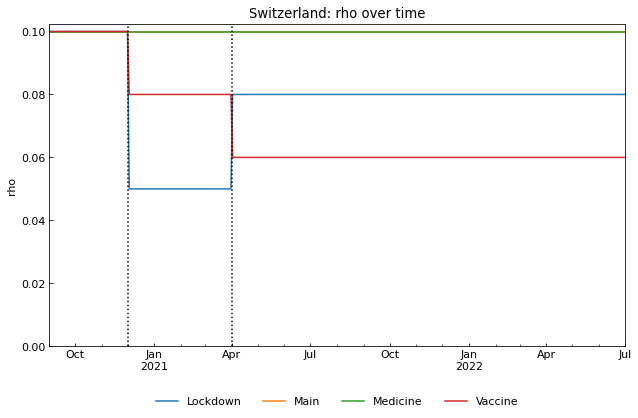

Scenario,Lockdown,Main,Medicine,Vaccine
Date,,,,
2020-09-01,0.1,0.1,0.1,0.1
2020-09-02,0.1,0.1,0.1,0.1
2020-09-03,0.1,0.1,0.1,0.1
2020-09-04,0.1,0.1,0.1,0.1
2020-09-05,0.1,0.1,0.1,0.1


In [103]:
# Show the history of rho as a dataframe and a figure
# we can set theta/kappa/rho/sigma for SIR model
snl.history(target="rho").head()
# snl.history(target="rho").tail()

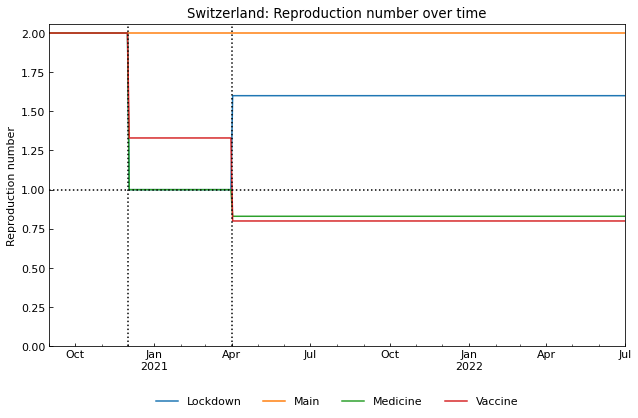

In [104]:
# Show the history of reproduction number
_ = snl.history(target="Rt")

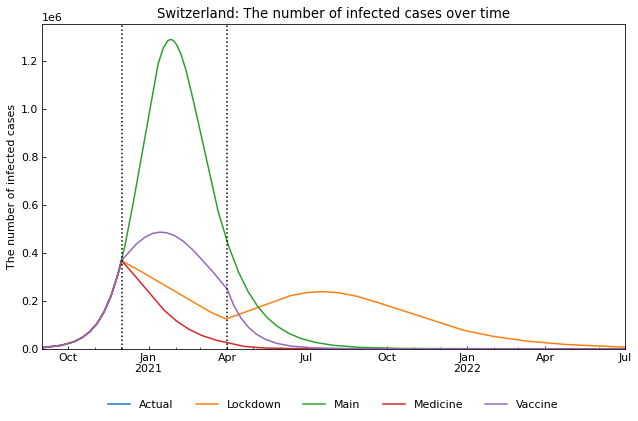

In [102]:
# The number of infected cases
_ = snl.history(target="Infected") #'Fatal', ....

### Simulating scenarios

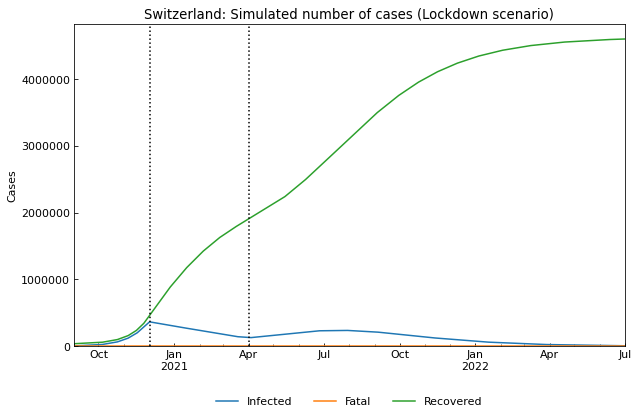

In [105]:
_ = snl.simulate(name = 'Lockdown')

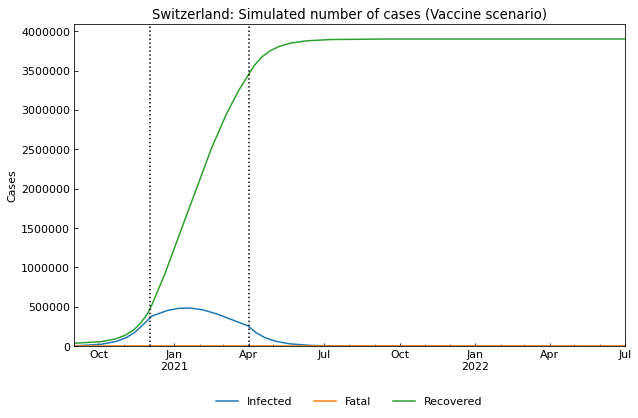

In [107]:
_ = snl.simulate(name = 'Vaccine')